**Input:** 
- UK Biobank cancer-related fields
- ACCEL dataset (Katori et al. 2022)


**Process:**
 - Extract the subset population with ACCEL dataset available
 - See whether cancer makes any difference in ACCEL features

**Output:**


# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [1]:
import collections
import csv
from datetime import datetime
import os
import numpy as np
import pandas as pd
from pathlib import Path
import polars as pl
import re
from matplotlib import pyplot as plt

from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm

from contextlib import redirect_stdout
from io import StringIO

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Draw flowcharts using Mermaid
import base64
from IPython.display import Image, display

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))


dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


In [2]:
DIR_SOURCE = os.path.join("data", "accel_ukbb", "split")
DIR_OUT = os.path.join("analysis", "specific", "analysis_20230427_01_ACCEL_cancer")

if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

In [12]:
mm("""
graph TD;
    UKBB[UKBB population: 502,386] --> ACCEL[ACCEL data available: 81,496];
    ACCEL --> C1[cancer record after accelerometry: 6,098];
    ACCEL --> C2[cancer record before accelerometry: 11,684];
    ACCEL --> C3[no cancer record: 63,714];
""")

print("----------------------")

mm("""
graph TD;
    classDef dark fill:#DDDDDD, stroke:#DDDDDD, font-size:12px
    UKBB[UKBB population: 502,386] --> ACCEL[ACCEL data available: 81,496];
    ACCEL -.-> C1[cancer record before accelerometry: 11,684]:::dark;
    ACCEL --> C2[cancer record after accelerometry: 6,098];
    ACCEL --> C3[no cancer record: 63,714];
""")


----------------------


## Functions

In [12]:
def merge_files(list_files, dir):
    list_files = [os.path.join(dir, file) for file in list_files]

    # Initialize an empty DataFrame
    df_merged = pl.DataFrame()
    
    print(datetime.now(), "Start processing", len(list_files), "files")

    # Loop over each file in the list and add it to the merged DataFrame
    for i, file in enumerate(list_files):
        func_print(i + 1)
        # Read in the current file as a DataFrame
        df_current = pl.read_csv(file, sep="\t")

        # Get the column name for the current file's specific column
        column_name = os.path.splitext(os.path.basename(file))[0]

        # Rename the specific column to the name of the current file
        #df_current = df_current.rename(columns={df_current.columns[1]: column_name})
        df_current = df_current.rename({df_current.columns[1]: column_name})

        # If this is the first file being added, simply set df_merged to df_current
        if df_merged.shape == (0, 0):
            df_merged = df_current

        # Otherwise, merge df_current with df_merged on the "eid" column
        else:
            df_merged = df_merged.join(df_current, on="eid", how="outer")

    return df_merged
    
    

def func_print(i):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}")
        
        
# Define the custom date conversion function
def convert_date_format(date_str: str) -> str:
    if date_str == "NA":
        formatted_date = "NA"
    else:
        date_obj = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")
        formatted_date = date_obj.strftime("%Y-%m-%d")
    return formatted_date


# Convert anything to np.float32
def pl_to_float(df):
    result = df.to_numpy()
    try:
        result = result.astype(float)
    except:
        if "-" in result[0]: # Date-time format
            # Convert the date strings to datetime objects
            result = np.array([datetime.fromisoformat(date_str) for date_str in result])

            # Extract the date component and convert to integer
            result = np.array([int(date_obj.timestamp()) for date_obj in result])
    return result


# Check normality
def test_normality(pheno_list_continuous, df):
    pval_min = 1
    for pheno in pheno_list_continuous:
        print(pheno)
        try:
            np_df = pl_to_float(df[pheno])
            pval = stats.kstest(np_df, "norm")[1]
            print("P-value =", pval)
            if not np.isnan(pval):
                pval_min = min(pval, pval_min)
        except:
            print("Skip because the data is not valid ")
    if pval_min < 0.05 / len(pheno_list_continuous):
        is_normal = False
    else:
        is_normal = True
    print()
    print("Minimum p-value = ", pval_min, ", therefore normality =", is_normal)

# Merge the relevant fields

In [6]:
list_files = [
"ukb671006_22286_40005-0.0.txt",
"ukb671006_22287_40005-1.0.txt",
"ukb671006_22288_40005-2.0.txt",
"ukb671006_22289_40005-3.0.txt",
"ukb671006_22290_40005-4.0.txt",
"ukb671006_22291_40005-5.0.txt",
"ukb671006_22292_40005-6.0.txt",
"ukb671006_22293_40005-7.0.txt",
"ukb671006_22294_40005-8.0.txt",
"ukb671006_22295_40005-9.0.txt",
"ukb671006_22296_40005-10.0.txt",
"ukb671006_22297_40005-11.0.txt",
"ukb671006_22298_40005-12.0.txt",
"ukb671006_22299_40005-13.0.txt",
"ukb671006_22300_40005-14.0.txt",
"ukb671006_22301_40005-15.0.txt",
"ukb671006_22302_40005-16.0.txt",
"ukb671006_22303_40005-17.0.txt",
"ukb671006_22304_40005-18.0.txt",
"ukb671006_22305_40005-19.0.txt",
"ukb671006_22306_40005-20.0.txt",
"ukb671006_22307_40005-21.0.txt",
"ukb671006_24430_90010-0.0.txt",
"ukb671006_28448_eid_old.txt",
"ukb671006_28449_day_num.txt",
"ukb671006_28450_ST_long_mean.txt",
"ukb671006_28451_ST_long_sd.txt",
"ukb671006_28452_WT_long_mean.txt",
"ukb671006_28453_WT_long_sd.txt",
"ukb671006_28454_ST_short_mean.txt",
"ukb671006_28455_ST_short_sd.txt",
"ukb671006_28456_WT_short_mean.txt",
"ukb671006_28457_WT_short_sd.txt",
"ukb671006_28458_long_window_len_mean.txt",
"ukb671006_28459_long_window_len_sd.txt",
"ukb671006_28460_long_window_num_mean.txt",
"ukb671006_28461_long_window_num_sd.txt",
"ukb671006_28462_short_window_len_mean.txt",
"ukb671006_28463_short_window_len_sd.txt",
"ukb671006_28464_short_window_num_mean.txt",
"ukb671006_28465_short_window_num_sd.txt",
"ukb671006_28466_phase_mean.txt",
"ukb671006_28467_phase_sd.txt",
"ukb671006_28468_max_period.txt",
"ukb671006_28469_amplitude.txt",
"ukb671006_28470_sleep_percentage.txt",
"ukb671006_28471_continuous_day.txt",
"ukb671006_28472_age.txt",
"ukb671006_28473_sex.txt",
"ukb671006_28474_cluster.txt",
"ukb671006_28475_group_eid_old.txt",
"ukb671006_28476_abnormal_group_eid_old.txt",
"ukb671006_28479_cluster_alphabet.txt",
"ukb671006_28480_group_five.txt",
"ukb671006_28481_group_eight.txt",
"ukb671006_28482_abnormal_group_eight.txt",]
df = merge_files(list_files, DIR_SOURCE)

2023-04-24 11:47:45.471587 Start processing 56 files
2023-04-24 11:47:45: 1
2023-04-24 11:47:47: 2
2023-04-24 11:47:51: 3
2023-04-24 11:47:57: 4
2023-04-24 11:48:02: 5
2023-04-24 11:48:06: 6
2023-04-24 11:48:12: 7
2023-04-24 11:48:16: 8
2023-04-24 11:48:21: 9
2023-04-24 11:48:25: 10
2023-04-24 11:49:08: 20
2023-04-24 11:49:58: 30
2023-04-24 11:50:59: 40
2023-04-24 11:51:46: 50


In [7]:
df

shape: (502386, 57)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_22 ┆ ukb671006_22 ┆ ... ┆ ukb671006_28 ┆ ukb671006_28 ┆ ukb671006_28 ┆ ukb671006_28 │
│ ---     ┆ 22286_4000 ┆ 287_40005-1. ┆ 288_40005-2. ┆     ┆ 479_cluster_ ┆ 480_group_fi ┆ 481_group_ei ┆ 482_abnormal │
│ i64     ┆ 5-0.0      ┆ 0            ┆ 0            ┆     ┆ alphabet     ┆ ve           ┆ ght          ┆ _group_e...  │
│         ┆ ---        ┆ ---          ┆ ---          ┆     ┆ ---          ┆ ---          ┆ ---          ┆ ---          │
│         ┆ str        ┆ str          ┆ str          ┆     ┆ str          ┆ str          ┆ str          ┆ str          │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000010 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 1000028 ┆ 2008-05-13 ┆ 2017-02-02   ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 1000034 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 1000045 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6024804 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 6024818 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ A            ┆ 1            ┆ A            ┆ NA           │
│ 6024820 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 6024833 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 40626 characters

# Date of cancer diagnosis
- Calculate the earliest date of cancer diagnosis
- Flag whether the cancer diagnosis is before or after the accelerometry measurement

In [8]:
cols_cancer_date = [
"ukb671006_22286_40005-0.0", 
"ukb671006_22287_40005-1.0", 
"ukb671006_22288_40005-2.0", 
"ukb671006_22289_40005-3.0", 
"ukb671006_22290_40005-4.0", 
"ukb671006_22291_40005-5.0", 
"ukb671006_22292_40005-6.0", 
"ukb671006_22293_40005-7.0", 
"ukb671006_22294_40005-8.0", 
"ukb671006_22295_40005-9.0", 
"ukb671006_22296_40005-10.0", 
"ukb671006_22297_40005-11.0", 
"ukb671006_22298_40005-12.0", 
"ukb671006_22299_40005-13.0", 
"ukb671006_22300_40005-14.0", 
"ukb671006_22301_40005-15.0", 
"ukb671006_22302_40005-16.0", 
"ukb671006_22303_40005-17.0", 
"ukb671006_22304_40005-18.0", 
"ukb671006_22305_40005-19.0", 
"ukb671006_22306_40005-20.0", 
"ukb671006_22307_40005-21.0", 
]

# convert the columns to Date
for i_col in cols_cancer_date:
    df = df.with_columns(pl.col(i_col).str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False))
    
# calculate the earliest date for each row
earliest_cancer = df[cols_cancer_date].min(axis=1)

# Preserve only the earliest date
df = df.with_column(earliest_cancer.alias("earliest_cancer")).drop(cols_cancer_date)

# Apply the custom function to the "ukb671006_24430_90010-0.0" column
df = (df.with_column(
    pl.col("ukb671006_24430_90010-0.0")
    .apply(convert_date_format, return_dtype=pl.Utf8)
    .str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False)
    .alias("ukb671006_24430_90010-0.0")
))

df

shape: (502386, 36)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_28 ┆ ukb671006_28 ┆ ... ┆ ukb671006_28 ┆ ukb671006_28 ┆ ukb671006_28 ┆ earliest_can │
│ ---     ┆ 24430_9001 ┆ 448_eid_old  ┆ 449_day_num  ┆     ┆ 480_group_fi ┆ 481_group_ei ┆ 482_abnormal ┆ cer          │
│ i64     ┆ 0-0.0      ┆ ---          ┆ ---          ┆     ┆ ve           ┆ ght          ┆ _group_e...  ┆ ---          │
│         ┆ ---        ┆ str          ┆ str          ┆     ┆ ---          ┆ ---          ┆ ---          ┆ date         │
│         ┆ date       ┆              ┆              ┆     ┆ str          ┆ str          ┆ str          ┆              │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000010 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ 1000028 ┆ 2014-10-31 ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ 2008-05-13   │
│ 1000034 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ 1000045 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6024804 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ 6024818 ┆ 2014-11-15 ┆ 6016103      ┆ 3.0          ┆ ... ┆ 1            ┆ A            ┆ NA           ┆ null         │
│ 6024820 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ 6024833 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 25574 characters

In [9]:
# Define a function to convert the date string into a single integer
def date_string_to_int(date_str):
    if not date_str:
        result = "NA"
    else:
        date_start = datetime.strptime("1970-10-10", '%Y-%m-%d').date()
        result = (date_str - date_start).days
    return result


accel_after_cancer = (df['ukb671006_24430_90010-0.0'] > df['earliest_cancer']).cast(pl.Boolean)

df_annotated = (df
                .with_column(accel_after_cancer.alias("accel_after_cancer"))
                .with_columns(pl.col('ukb671006_24430_90010-0.0')
                              .apply(date_string_to_int)
                              .alias("ukb671006_24430_90010-0.0_days")
                              .cast(pl.Int32, strict=False)
                             )
                .with_columns(pl.col('earliest_cancer')
                              .apply(date_string_to_int)
                              .alias("earliest_cancer_days")
                              .cast(pl.Int32, strict=False)
                             )                              
               )
df_annotated

shape: (502386, 39)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_28 ┆ ukb671006_28 ┆ ... ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 24430_9001 ┆ 448_eid_old  ┆ 449_day_num  ┆     ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0-0.0      ┆ ---          ┆ ---          ┆     ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---        ┆ str          ┆ str          ┆     ┆ date         ┆ bool         ┆ ---          ┆ i32          │
│         ┆ date       ┆              ┆              ┆     ┆              ┆              ┆ i32          ┆              │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000010 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ 1000028 ┆ 2014-10-31 ┆ NA           ┆ NA           ┆ ... ┆ 2008-05-13   ┆ true         ┆ 16092        ┆ 13730        │
│ 1000034 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ 1000045 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6024804 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ 6024818 ┆ 2014-11-15 ┆ 6016103      ┆ 3.0          ┆ ... ┆ null         ┆ null         ┆ 16107        ┆ null         │
│ 6024820 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ 6024833 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 26931 characters

In [10]:
FILE_OUT = os.path.join(DIR_OUT, "filtered_annotated.csv")
df_annotated.write_csv(FILE_OUT)

# Comparison of "accelerometry before/after/without cancer" - overall chisq/t-test

In [3]:
file = os.path.join(DIR_OUT, "filtered_annotated.csv")
df_annotated = (pl.read_csv(file, infer_schema_length=None)
               .filter(pl.col("ukb671006_28448_eid_old") != "NA")
               )
df_annotated

shape: (81496, 39)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_28 ┆ ukb671006_28 ┆ ... ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 24430_9001 ┆ 448_eid_old  ┆ 449_day_num  ┆     ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0-0.0      ┆ ---          ┆ ---          ┆     ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---        ┆ str          ┆ str          ┆     ┆ str          ┆ bool         ┆ ---          ┆ i64          │
│         ┆ str        ┆              ┆              ┆     ┆              ┆              ┆ i64          ┆              │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000076 ┆ 2014-03-17 ┆ 3705388      ┆ 6.0          ┆ ... ┆ null         ┆ null         ┆ 15864        ┆ null         │
│ 1000091 ┆ 2015-06-27 ┆ 3867761      ┆ 6.0          ┆ ... ┆ null         ┆ null         ┆ 16331        ┆ null         │
│ 1000162 ┆ 2015-01-28 ┆ 3077861      ┆ 4.0          ┆ ... ┆ null         ┆ null         ┆ 16181        ┆ null         │
│ 1000171 ┆ 2014-09-26 ┆ 5292419      ┆ 5.0          ┆ ... ┆ null         ┆ null         ┆ 16057        ┆ null         │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6024605 ┆ 2013-08-02 ┆ 1910696      ┆ 6.0          ┆ ... ┆ null         ┆ null         ┆ 15637        ┆ null         │
│ 6024698 ┆ 2013-07-22 ┆ 1252952      ┆ 5.0          ┆ ... ┆ null         ┆ null         ┆ 15626        ┆ null         │
│ 6024737 ┆ 2014-06-09 ┆ 4741522      ┆ 6.0          ┆ ... ┆ null         ┆ null         ┆ 15948        ┆ null         │
│ 6024818 ┆ 2014-11-15 ┆ 6016103      ┆ 3.0          ┆ ... ┆ null         ┆ null         ┆ 16107        ┆ null         │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 30087 characters

In [4]:
df_accel_before_cancer = df_annotated.filter(pl.col("accel_after_cancer") == False)
df_accel_after_cancer = df_annotated.filter(pl.col("accel_after_cancer") == True)
df_accel_with_cancer = df_annotated.filter(pl.col("accel_after_cancer").is_not_null())
df_accel_without_cancer = df_annotated.filter(pl.col("accel_after_cancer").is_null())

In [5]:
df_accel_after_cancer

shape: (11_684, 39)
┌─────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_24 ┆ ukb671006_28 ┆ ukb671006_28 ┆ … ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 430_90010-0. ┆ 448_eid_old  ┆ 449_day_num  ┆   ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0            ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---          ┆ str          ┆ str          ┆   ┆ str          ┆ bool         ┆ ---          ┆ i64          │
│         ┆ str          ┆              ┆              ┆   ┆              ┆              ┆ i64          ┆              │
╞═════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1001184 ┆ 2015-11-20   ┆ 4024816      ┆ 6.0          ┆ … ┆ 2007-02-23   ┆ true         ┆ 16477        ┆ 13285        │
│ 1001439 ┆ 2015-03-21   ┆ 1238327      ┆ 6.0          ┆ … ┆ 2001-03-30   ┆ true         ┆ 16233        ┆ 11129        │
│ 1001725 ┆ 2014-10-17   ┆ 2583344      ┆ 6.0          ┆ … ┆ 2010-11-24   ┆ true         ┆ 16078        ┆ 14655        │
│ 1001889 ┆ 2015-10-14   ┆ 4665024      ┆ 6.0          ┆ … ┆ 2000-08-22   ┆ true         ┆ 16440        ┆ 10909        │
│ …       ┆ …            ┆ …            ┆ …            ┆ … ┆ …            ┆ …            ┆ …            ┆ …            │
│ 6021735 ┆ 2015-01-28   ┆ 5582309      ┆ 6.0          ┆ … ┆ 2011-08-03   ┆ true         ┆ 16181        ┆ 14907        │
│ 6022189 ┆ 2014-09-20   ┆ 1182093      ┆ 6.0          ┆ … ┆ 1996-08-06   ┆ true         ┆ 16051        ┆ 9432         │
│ 6023069 ┆ 2015-09-26   ┆ 4069378      ┆ 6.0          ┆ … ┆ 2007-06-18   ┆ true         ┆ 16422        ┆ 13400        │
│ 6023283 ┆ 2014-04-16   ┆ 5906221      ┆ 6.0          ┆ … ┆ 2011-08-19   ┆ true         ┆ 15894        ┆ 14923        │
└─────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 10000 exceeded with 27010 characters

In [8]:
df_accel_before_cancer

shape: (6098, 39)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_28 ┆ ukb671006_28 ┆ ... ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 24430_9001 ┆ 448_eid_old  ┆ 449_day_num  ┆     ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0-0.0      ┆ ---          ┆ ---          ┆     ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---        ┆ str          ┆ str          ┆     ┆ str          ┆ bool         ┆ ---          ┆ i64          │
│         ┆ str        ┆              ┆              ┆     ┆              ┆              ┆ i64          ┆              │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000337 ┆ 2014-11-15 ┆ 5579755      ┆ 6.0          ┆ ... ┆ 2016-04-04   ┆ false        ┆ 16107        ┆ 16613        │
│ 1002455 ┆ 2013-07-20 ┆ 4988731      ┆ 6.0          ┆ ... ┆ 2019-02-09   ┆ false        ┆ 15624        ┆ 17654        │
│ 1002651 ┆ 2013-07-20 ┆ 2962276      ┆ 6.0          ┆ ... ┆ 2014-06-17   ┆ false        ┆ 15624        ┆ 15956        │
│ 1002720 ┆ 2014-11-15 ┆ 2112328      ┆ 6.0          ┆ ... ┆ 2018-07-28   ┆ false        ┆ 16107        ┆ 17458        │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6019212 ┆ 2014-09-20 ┆ 5292311      ┆ 6.0          ┆ ... ┆ 2018-09-06   ┆ false        ┆ 16051        ┆ 17498        │
│ 6021036 ┆ 2013-10-24 ┆ 2219450      ┆ 6.0          ┆ ... ┆ 2018-04-20   ┆ false        ┆ 15720        ┆ 17359        │
│ 6022983 ┆ 2015-09-21 ┆ 3937382      ┆ 6.0          ┆ ... ┆ 2017-03-16   ┆ false        ┆ 16417        ┆ 16959        │
│ 6023473 ┆ 2015-05-15 ┆ 4653033      ┆ 6.0          ┆ ... ┆ 2018-05-21   ┆ false        ┆ 16288        ┆ 17390        │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 30779 characters

In [7]:
df_accel_with_cancer

shape: (17_782, 39)
┌─────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_24 ┆ ukb671006_28 ┆ ukb671006_28 ┆ … ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 430_90010-0. ┆ 448_eid_old  ┆ 449_day_num  ┆   ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0            ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---          ┆ str          ┆ str          ┆   ┆ str          ┆ bool         ┆ ---          ┆ i64          │
│         ┆ str          ┆              ┆              ┆   ┆              ┆              ┆ i64          ┆              │
╞═════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000337 ┆ 2014-11-15   ┆ 5579755      ┆ 6.0          ┆ … ┆ 2016-04-04   ┆ false        ┆ 16107        ┆ 16613        │
│ 1001184 ┆ 2015-11-20   ┆ 4024816      ┆ 6.0          ┆ … ┆ 2007-02-23   ┆ true         ┆ 16477        ┆ 13285        │
│ 1001439 ┆ 2015-03-21   ┆ 1238327      ┆ 6.0          ┆ … ┆ 2001-03-30   ┆ true         ┆ 16233        ┆ 11129        │
│ 1001725 ┆ 2014-10-17   ┆ 2583344      ┆ 6.0          ┆ … ┆ 2010-11-24   ┆ true         ┆ 16078        ┆ 14655        │
│ …       ┆ …            ┆ …            ┆ …            ┆ … ┆ …            ┆ …            ┆ …            ┆ …            │
│ 6022983 ┆ 2015-09-21   ┆ 3937382      ┆ 6.0          ┆ … ┆ 2017-03-16   ┆ false        ┆ 16417        ┆ 16959        │
│ 6023069 ┆ 2015-09-26   ┆ 4069378      ┆ 6.0          ┆ … ┆ 2007-06-18   ┆ true         ┆ 16422        ┆ 13400        │
│ 6023283 ┆ 2014-04-16   ┆ 5906221      ┆ 6.0          ┆ … ┆ 2011-08-19   ┆ true         ┆ 15894        ┆ 14923        │
│ 6023473 ┆ 2015-05-15   ┆ 4653033      ┆ 6.0          ┆ … ┆ 2018-05-21   ┆ false        ┆ 16288        ┆ 17390        │
└─────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 10000 exceeded with 26966 characters

In [8]:
df_accel_without_cancer

eid,ukb671006_24430_90010-0.0,ukb671006_28448_eid_old,ukb671006_28449_day_num,ukb671006_28450_ST_long_mean,ukb671006_28451_ST_long_sd,ukb671006_28452_WT_long_mean,ukb671006_28453_WT_long_sd,ukb671006_28454_ST_short_mean,ukb671006_28455_ST_short_sd,ukb671006_28456_WT_short_mean,ukb671006_28457_WT_short_sd,ukb671006_28458_long_window_len_mean,ukb671006_28459_long_window_len_sd,ukb671006_28460_long_window_num_mean,ukb671006_28461_long_window_num_sd,ukb671006_28462_short_window_len_mean,ukb671006_28463_short_window_len_sd,ukb671006_28464_short_window_num_mean,ukb671006_28465_short_window_num_sd,ukb671006_28466_phase_mean,ukb671006_28467_phase_sd,ukb671006_28468_max_period,ukb671006_28469_amplitude,ukb671006_28470_sleep_percentage,ukb671006_28471_continuous_day,ukb671006_28472_age,ukb671006_28473_sex,ukb671006_28474_cluster,ukb671006_28475_group_eid_old,ukb671006_28476_abnormal_group_eid_old,ukb671006_28479_cluster_alphabet,ukb671006_28480_group_five,ukb671006_28481_group_eight,ukb671006_28482_abnormal_group_eight,earliest_cancer,accel_after_cancer,ukb671006_24430_90010-0.0_days,earliest_cancer_days
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,i64,i64
1000076,"""2014-03-17""","""3705388""","""6.0""","""408.0833333333…","""83.08450350229…","""53.91666666666…","""22.49891972715…","""34.66666666666…","""55.54177606890…","""2.833333333333…","""4.624812308503…","""462.0""","""93.65183749754…","""1.0""","""0.0""","""56.25""","""49.82030208659…","""0.666666666666…","""0.745355992499…","""960.75""","""35.79658968859…","""1439.999999999…","""0.641583920993…","""0.307754629629…","""6.0""","""69""","""0""","""2_0""","""4b""","""NA""","""F""","""4""","""G""","""NA""",null,null,15864,null
1000091,"""2015-06-27""","""3867761""","""6.0""","""215.3333333333…","""98.56624957639…","""23.0""","""14.30908802125…","""73.33333333333…","""83.99338598299…","""22.91666666666…","""27.38067546443…","""286.0""","""29.75903224232…","""0.833333333333…","""0.372677996249…","""36.09375""","""38.21003580131…","""2.666666666666…","""1.699673171197…","""960.4166666666…","""58.07855073566…","""1421.999999999…","""0.477603314889…","""0.207349537037…","""6.0""","""67""","""1""","""1_0""","""3b""","""NA""","""C""","""3""","""E""","""NA""",null,null,16331,null
1000162,"""2015-01-28""","""3077861""","""4.0""","""512.375""","""45.02273731127…","""110.625""","""56.50594548363…","""39.125""","""38.66421957055…","""18.75""","""21.18519530238…","""623.0""","""99.46041926314…","""1.0""","""0.0""","""46.3""","""35.20596540360…","""1.25""","""1.089724735885…","""926.75""","""6.675514961409…","""1439.999999999…","""0.740724781467…","""0.392534722222…","""4.0""","""51""","""1""","""2_0""","""4b""","""NA""","""F""","""4""","""G""","""NA""",null,null,16181,null
1000171,"""2014-09-26""","""5292419""","""5.0""","""461.3""","""56.67503859725…","""64.6""","""33.89896753589…","""4.0""","""8.0""","""0.8""","""1.600000000000…","""525.9""","""49.81907265295…","""1.0""","""0.0""","""24.0""","""0.0""","""0.2""","""0.400000000000…","""895.3""","""10.42401074443…","""1439.999999999…","""0.670661740528…","""0.325625""","""5.0""","""59""","""0""","""2_0""","""4b""","""NA""","""F""","""4""","""G""","""NA""",null,null,16057,null
1000196,"""2015-10-22""","""1574881""","""6.0""","""425.75""","""47.03256850311…","""27.91666666666…","""7.683405639573…","""24.5""","""32.60112472497…","""10.66666666666…","""12.17123202017…","""453.6666666666…","""46.80782223327…","""1.0""","""0.0""","""52.75""","""43.49928160326…","""0.666666666666…","""0.471404520791…","""992.75""","""42.70221500890…","""1439.999999999…","""0.655325496636…","""0.318171296296…","""6.0""","""54""","""0""","""2_0""","""4b""","""NA""","""F""","""4""","""G""","""NA""",null,null,16448,null
1000209,"""2014-11-15""","""5256236""","""5.0""","""412.1""","""99.94718605343…","""43.4""","""6.952697318307…","""16.5""","""27.82804340948…","""14.0""",

limit_output extension: Maximum message size of 10000 exceeded with 26413 characters

## The datasets do not follow normal distribution

In [11]:
test_normality(pheno_list_continuous, df_accel_before_cancer)
print()
test_normality(pheno_list_continuous, df_accel_after_cancer)
print()
test_normality(pheno_list_continuous, df_accel_without_cancer)

ukb671006_28450_ST_long_mean
P-value = 0.0
ukb671006_28451_ST_long_sd
P-value = 0.0
ukb671006_28452_WT_long_mean
P-value = 0.0
ukb671006_28453_WT_long_sd
P-value = 0.0
ukb671006_28454_ST_short_mean
P-value = 0.0
ukb671006_28455_ST_short_sd
P-value = 0.0
ukb671006_28456_WT_short_mean
P-value = 0.0
ukb671006_28457_WT_short_sd
P-value = 0.0
ukb671006_28458_long_window_len_mean
P-value = 0.0
ukb671006_28459_long_window_len_sd
P-value = 0.0
ukb671006_28460_long_window_num_mean
P-value = 0.0
ukb671006_28461_long_window_num_sd
P-value = 0.0
ukb671006_28462_short_window_len_mean
P-value = 0.0
ukb671006_28463_short_window_len_sd
P-value = 0.0
ukb671006_28464_short_window_num_mean
P-value = 0.0
ukb671006_28465_short_window_num_sd
P-value = 0.0
ukb671006_28466_phase_mean
P-value = 0.0
ukb671006_28467_phase_sd
P-value = 0.0
ukb671006_28468_max_period
P-value = 0.0
ukb671006_28469_amplitude
P-value = 0.0
ukb671006_28470_sleep_percentage
P-value = 0.0
ukb671006_28472_age
P-value = 0.0
ukb671006_2443

## Enlarge

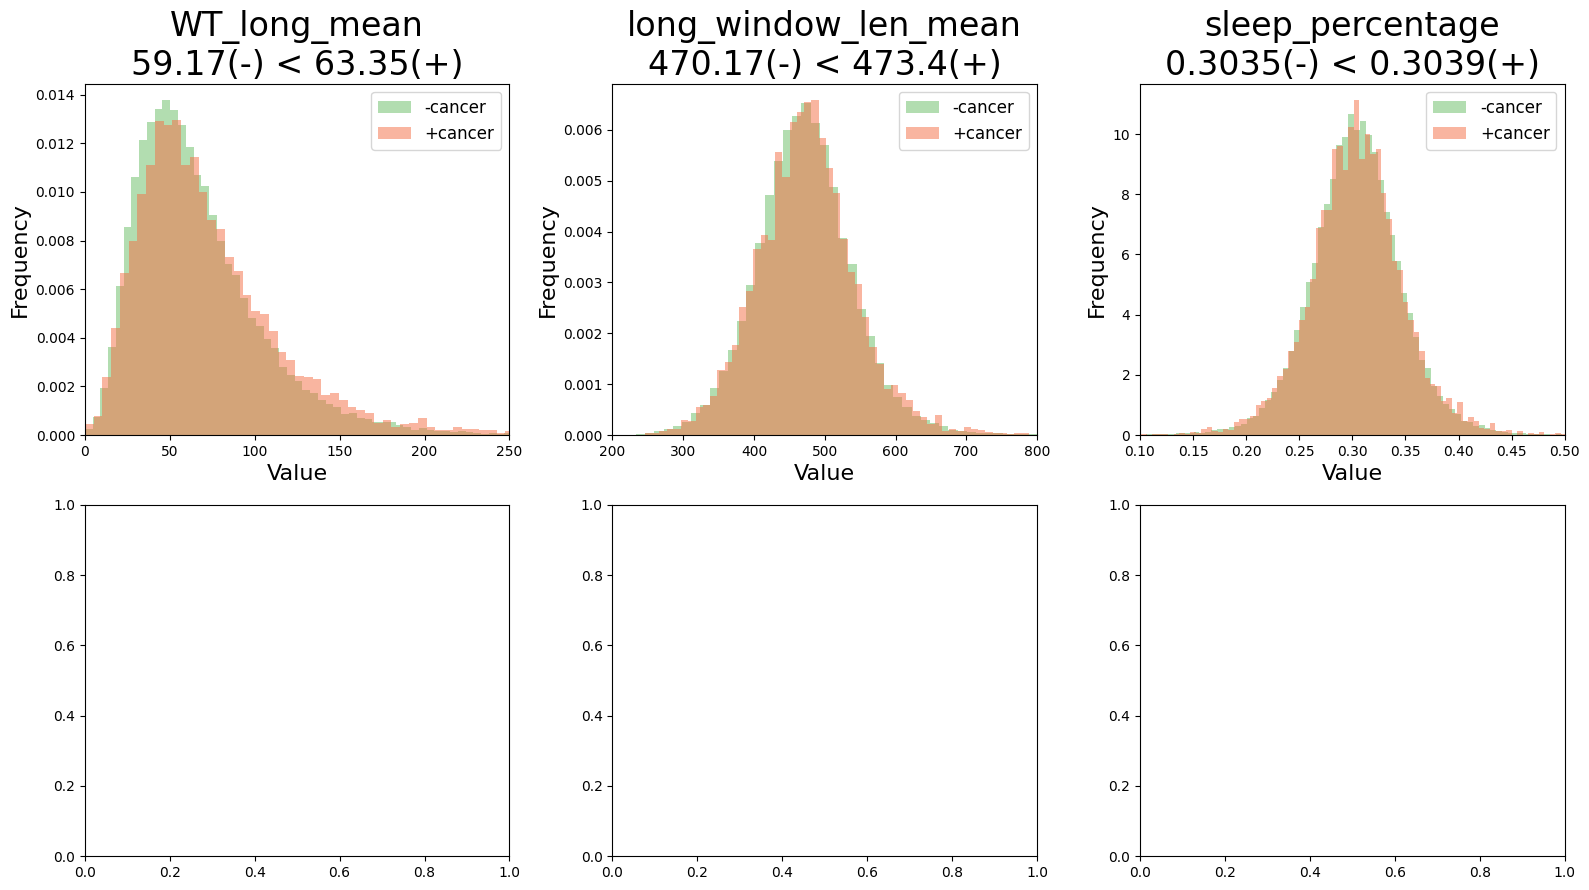

------------------------------------------------


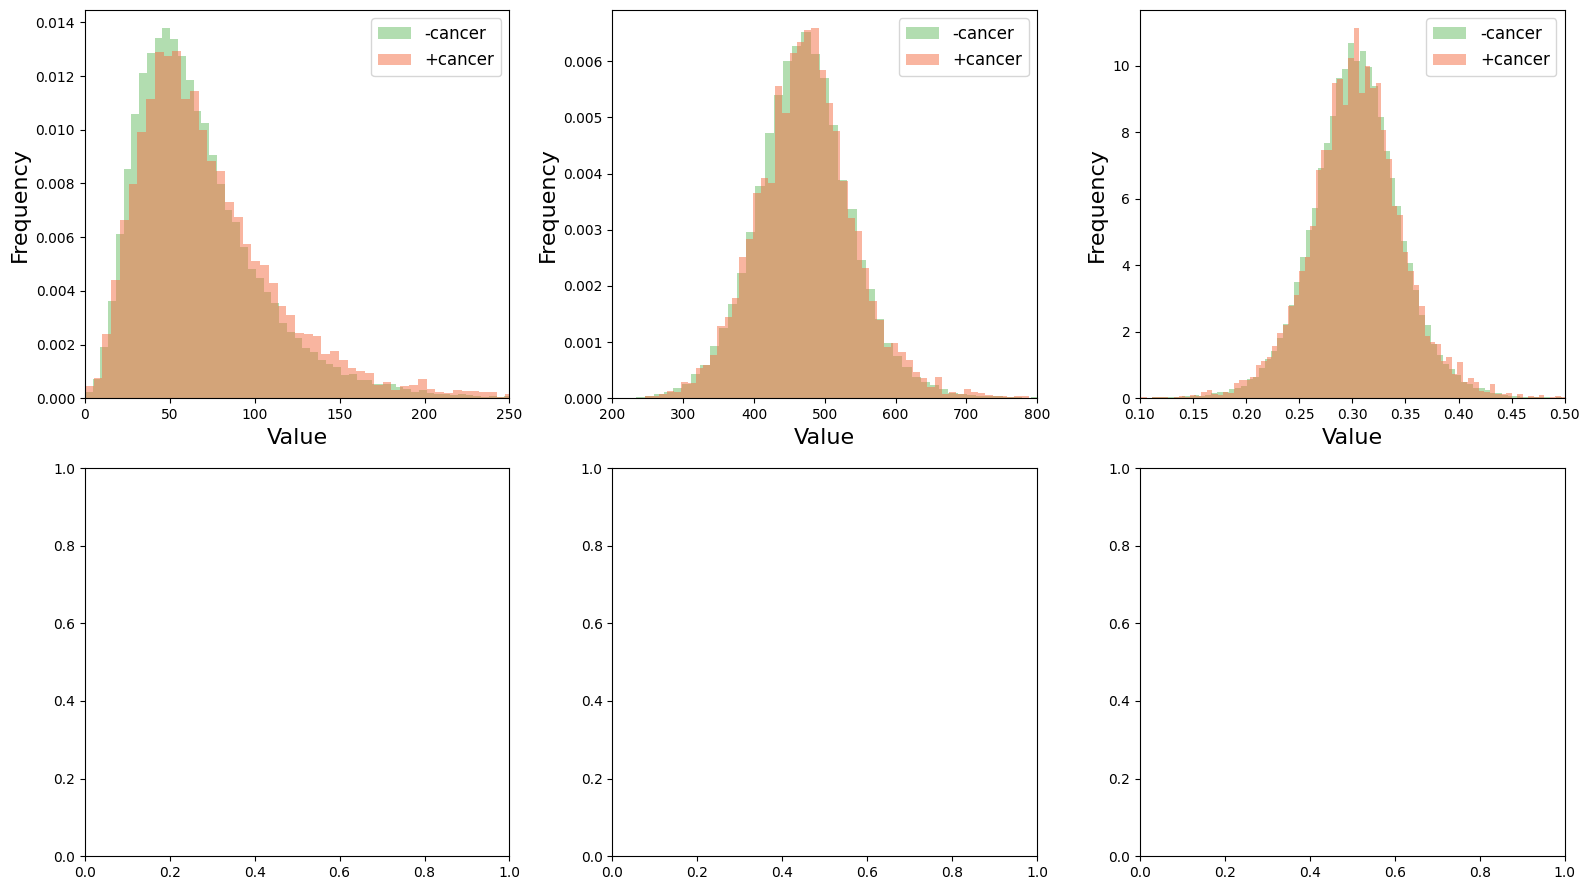

In [23]:
# Round two numbers to a precision with which difference is evident
def auto_prec_dif(x1, x2): 
    i = 2
    while i < 10:
        _x1 = np.round(x1, i)
        _x2 = np.round(x2, i)
        if _x1 != _x2: # Stop when difference is evident
            break
        else:
            i += 1
    return _x1, _x2

def plot_continuous_enlarge(df1, df2, plot_list, with_title):
    fig, axes = plt.subplots(2, 3, tight_layout=True, figsize=[16, 9])
    for i, (pheno, suffix, list_range) in enumerate(plot_list, 1):
        plot_x = int((i-1) / 3) + 1
        plot_y = i % 3
        
        np_before = np.array([])
        np_after = np.array([])

        # Calculate mean, median, and standard deviation for the two dataframes
        try:
            np_before = pl_to_float(df1[pheno])
            np_after = pl_to_float(df2[pheno])
            np_before = np_before[~np.isnan(np_before)]
            np_after = np_after[~np.isnan(np_after)]
        except:
            print("Skip because the matching data does not exist in both datasets")
            exit

        if len(np_before) < 10:
            print("Skip because the matching data does not exist in both datasets")
            exit
        if len(np_after) < 10:
            print("Skip because the matching data does not exist in both datasets")
            exit

        median_before = np.median(np_before)
        median_after = np.median(np_after)
        
        median_before, median_after = auto_prec_dif(median_before, median_after)
        
        if median_before < median_after:
            sign = ">"
        else:
            sign = "<"

        # Plot the distribution of the pheno column for each dataframe
        sub_plot = axes[plot_x-1, plot_y-1]
        sub_plot.set_xlim(list_range[0], list_range[1]) 
        sub_plot.hist(np_after, alpha=0.5, label="-cancer", density=True, bins=100, color='#66bd63')
        sub_plot.hist(np_before, alpha=0.5, label="+cancer", density=True, bins=100, color='#f46d43')
        sub_plot.legend(loc="upper right", fontsize=12)
        if with_title == True:
            sub_plot.set_title(suffix + "\n" + \
                               str(median_after) + "(-) " + sign + " " + str(median_before) + "(+)",
                              fontsize=24)
        sub_plot.set_xlabel("Value", fontsize=16)
        sub_plot.set_ylabel("Frequency", fontsize=16)
    plt.show()
    

plot_list = [
["ukb671006_28452_WT_long_mean", "WT_long_mean", [0, 250]],
["ukb671006_28458_long_window_len_mean", "long_window_len_mean", [200, 800]],
["ukb671006_28470_sleep_percentage", "sleep_percentage", [0.1, 0.5]],
]
    
plot_continuous_enlarge(df_accel_before_cancer, df_accel_without_cancer, plot_list, True)
print("------------------------------------------------")
plot_continuous_enlarge(df_accel_before_cancer, df_accel_without_cancer, plot_list, False)

## Correlation between top variables?
Especially with:
- Age
- Sex

In [22]:
list_top_phenotypes = ["ukb671006_28452_WT_long_mean", 
"ukb671006_28456_WT_short_mean", 
"ukb671006_28454_ST_short_mean", 
"ukb671006_28464_short_window_num_mean",
"ukb671006_28467_phase_sd"]

# With age
print("With age")
for pheno in list_top_phenotypes:
    r, pval = stats.pearsonr(df_accel_before_cancer["ukb671006_28472_age"].cast(pl.Float32), 
                             df_accel_before_cancer[pheno].cast(pl.Float32))
    print("Phenotype:", pheno, "r, p-value =", r, pval)


print()

# With sex
print("With sex")
for pheno in list_top_phenotypes:
    r, pval = stats.pearsonr(df_accel_before_cancer["ukb671006_28473_sex"].cast(pl.Float32), 
                             df_accel_before_cancer[pheno].cast(pl.Float32))
    print("Phenotype:", pheno, "r, p-value =", r, pval)

With age
Phenotype: ukb671006_28452_WT_long_mean r, p-value = 0.10709251514704159 5.062645236865369e-17
Phenotype: ukb671006_28456_WT_short_mean r, p-value = 0.12638272364042769 3.8847149920239744e-23
Phenotype: ukb671006_28454_ST_short_mean r, p-value = 0.15557703232233921 2.402560071562606e-34
Phenotype: ukb671006_28464_short_window_num_mean r, p-value = 0.17722211770759888 3.285084398344547e-44
Phenotype: ukb671006_28467_phase_sd r, p-value = -0.14210770155458555 7.040316534324658e-29

With sex
Phenotype: ukb671006_28452_WT_long_mean r, p-value = 0.15948262693004264 5.0089321682485086e-36
Phenotype: ukb671006_28456_WT_short_mean r, p-value = 0.09894884923605396 9.610100462684633e-15
Phenotype: ukb671006_28454_ST_short_mean r, p-value = -0.0014304906791633024 0.9110741775339937
Phenotype: ukb671006_28464_short_window_num_mean r, p-value = 0.09020978536158014 1.6964361882183514e-12
Phenotype: ukb671006_28467_phase_sd r, p-value = 0.023802359084088946 0.06308369537869532


# Eliminate confounding factors by linear regression
Confounding factors:
- 'ukb671006_28472_age',
- 'ukb671006_28473_sex',
- 'ukb671006_28449_day_num',
- 'ukb671006_28471_continuous_day',
- 'ukb671006_24430_90010-0.0_days',

## Preparation

In [18]:
df_comparison = pl.concat([
    df_accel_before_cancer.with_columns(pl.Series([1] * len(df_accel_before_cancer)).alias("cancer")),
    df_accel_without_cancer.with_columns(pl.Series([0] * len(df_accel_without_cancer)).alias("cancer"))
])


# Categorical variables
pheno_list_categorical = [
    "ukb671006_28475_group_eid_old",
    "ukb671006_28476_abnormal_group_eid_old",
]

# Continuous variables
pheno_list_continuous = [
    "ukb671006_28450_ST_long_mean",
    "ukb671006_28451_ST_long_sd",
    "ukb671006_28452_WT_long_mean",
    "ukb671006_28453_WT_long_sd",
    "ukb671006_28454_ST_short_mean",
    "ukb671006_28455_ST_short_sd",
    "ukb671006_28456_WT_short_mean",
    "ukb671006_28457_WT_short_sd",
    "ukb671006_28458_long_window_len_mean",
    "ukb671006_28459_long_window_len_sd",
    "ukb671006_28460_long_window_num_mean",
    "ukb671006_28461_long_window_num_sd",
    "ukb671006_28462_short_window_len_mean",
    "ukb671006_28463_short_window_len_sd",
    "ukb671006_28464_short_window_num_mean",
    "ukb671006_28465_short_window_num_sd",
    "ukb671006_28466_phase_mean",
    "ukb671006_28467_phase_sd",
    "ukb671006_28468_max_period",
    "ukb671006_28469_amplitude",
    "ukb671006_28470_sleep_percentage",
]


# Confounding factors
pheno_list_confounding = [
    'ukb671006_28472_age',
    'ukb671006_28473_sex',
    'ukb671006_28449_day_num',
    'ukb671006_28471_continuous_day',
    'ukb671006_24430_90010-0.0_days',
]

result_categorical = [["Phenotype", "Value", "ATE", "Warning"]]


# Convert to proper types
for pheno in (pheno_list_continuous + pheno_list_confounding):
    df_comparison = df_comparison.with_columns(pheno, df_comparison[pheno].cast(pl.Float32))
    
# Convert categorical variables to one-hot
for pheno in pheno_list_categorical:
    one_hot = df_comparison[pheno].to_dummies()
    df_comparison = pl.concat([df_comparison, one_hot], how="horizontal").drop(pheno)

    
# Unnecessary fields
pheno_list_drop = [
    "eid",
    "ukb671006_24430_90010-0.0",
    "ukb671006_28448_eid_old",
    "ukb671006_28474_cluster",
    "ukb671006_28479_cluster_alphabet",
    "ukb671006_28480_group_five",
    "ukb671006_28481_group_eight",
    "ukb671006_28482_abnormal_group_eight",
    "earliest_cancer", # Data only exists for the cancer group
    'earliest_cancer_days', # Data only exists for the cancer group
    "accel_after_cancer",  
    "ukb671006_28475_group_eid_old_NA",
    "ukb671006_28476_abnormal_group_eid_old_NA",    
]

df_comparison = df_comparison.drop(pheno_list_drop)

pheno_list = (df_comparison.columns)
pheno_list.remove("cancer")

df_comparison

shape: (69812, 43)
┌────────────┬────────────┬────────────┬────────────┬─────┬───────────────┬──────────────┬──────────────┬──────────────┐
│ ukb671006_ ┆ ukb671006_ ┆ ukb671006_ ┆ ukb671006_ ┆ ... ┆ ukb671006_284 ┆ ukb671006_28 ┆ ukb671006_28 ┆ ukb671006_28 │
│ 28449_day_ ┆ 28450_ST_l ┆ 28451_ST_l ┆ 28452_WT_l ┆     ┆ 76_abnormal_g ┆ 476_abnormal ┆ 476_abnormal ┆ 476_abnormal │
│ num        ┆ ong_mean   ┆ ong_sd     ┆ ong_mean   ┆     ┆ roup_e...     ┆ _group_e...  ┆ _group_e...  ┆ _group_e...  │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆     ┆ ---           ┆ ---          ┆ ---          ┆ ---          │
│ f32        ┆ f32        ┆ f32        ┆ f32        ┆     ┆ u8            ┆ u8           ┆ u8           ┆ u8           │
╞════════════╪════════════╪════════════╪════════════╪═════╪═══════════════╪══════════════╪══════════════╪══════════════╡
│ 6.0        ┆ 399.166656 ┆ 56.688965  ┆ 71.0       ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 6.0        ┆ 380.0      ┆ 37.061886  ┆ 52.166668  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 6.0        ┆ 424.5      ┆ 85.671371  ┆ 72.0       ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 6.0        ┆ 431.666656 ┆ 38.97934   ┆ 109.916664 ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ ...        ┆ ...        ┆ ...        ┆ ...        ┆ ... ┆ ...           ┆ ...          ┆ ...          ┆ ...          │
│ 6.0        ┆ 317.0      ┆ 64.845329  ┆ 66.833336  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 5.0        ┆ 424.0      ┆ 42.46999   ┆ 45.400002  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 6.0        ┆ 387.0      ┆ 34.372955  ┆ 80.916664  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 3.0        ┆ 552.5      ┆ 163.415115 ┆ 298.833344 ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
└────────────┴────────────┴────────────┴────────────┴─────┴───────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 20519 characters

In [10]:
df_comparison.columns

['ukb671006_28449_day_num',
 'ukb671006_28450_ST_long_mean',
 'ukb671006_28451_ST_long_sd',
 'ukb671006_28452_WT_long_mean',
 'ukb671006_28453_WT_long_sd',
 'ukb671006_28454_ST_short_mean',
 'ukb671006_28455_ST_short_sd',
 'ukb671006_28456_WT_short_mean',
 'ukb671006_28457_WT_short_sd',
 'ukb671006_28458_long_window_len_mean',
 'ukb671006_28459_long_window_len_sd',
 'ukb671006_28460_long_window_num_mean',
 'ukb671006_28461_long_window_num_sd',
 'ukb671006_28462_short_window_len_mean',
 'ukb671006_28463_short_window_len_sd',
 'ukb671006_28464_short_window_num_mean',
 'ukb671006_28465_short_window_num_sd',
 'ukb671006_28466_phase_mean',
 'ukb671006_28467_phase_sd',
 'ukb671006_28468_max_period',
 'ukb671006_28469_amplitude',
 'ukb671006_28470_sleep_percentage',
 'ukb671006_28471_continuous_day',
 'ukb671006_28472_age',
 'ukb671006_28473_sex',
 'ukb671006_24430_90010-0.0_days',
 'cancer',
 'ukb671006_28475_group_eid_old_1',
 'ukb671006_28475_group_eid_old_2a',
 'ukb671006_28475_group_eid_

## Centered on single variables
- Simple regression
- Multiple regression (single variable + confounding factors)

In [14]:
def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore


def func_linreg(df_comparison, pheno_list, pheno_list_confounding, with_confounding, file_name):
    result_list = [["Phenotype", 
                    "params_intercept", "params_X", 
                    "pval_intercept", "pval_X", 
                    "r^2", "Condition_number"]]
    _pheno_list = pheno_list
    
    if with_confounding == True:
        for pheno in pheno_list_confounding:
            try:
                _pheno_list.remove(pheno)
            except:
                pass
    
    for pheno in _pheno_list:
        # print(pheno)
        if with_confounding == True: # With confounding factors
            pheno_list_X_Y = [pheno, "cancer"] + pheno_list_confounding
            pheno_list_X = [pheno] + pheno_list_confounding
        else: # Simple regression only
            pheno_list_X_Y = [pheno, "cancer"]
            pheno_list_X = [pheno]

        df_temp = df_comparison[pheno_list_X_Y].drop_nulls()

        X = df_temp[pheno_list_X].to_numpy()
        X = zscore(X, axis=0) # Normalize
        Y = df_temp["cancer"].to_numpy()

        # Add a constant to the independent variable
        X = sm.add_constant(X)

        # Perform the linear regression analysis
        model = sm.OLS(Y, X)
        results = model.fit()

        # Summary of the linear regression analysis
        # print(results.summary())
        result_list.append([pheno,
                            results.params[0], results.params[1],
                            results.pvalues[0],results.pvalues[1],
                            results.rsquared,
                           results.condition_number,
                           ])
    file_out = os.path.join(DIR_OUT, file_name)
    with open(file_out, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(result_list)
    print("Exported to", file_out)
    
    return result_list

In [15]:
result_list_without_confounding = func_linreg(df_comparison, pheno_list, pheno_list_confounding, 
                                              False, "linear_regression_single_without_confounding.csv")
result_list_with_confounding = func_linreg(df_comparison, pheno_list, pheno_list_confounding, 
                                           True, "linear_regression_single_with_all_confounding.csv")

Exported to analysis\specific\analysis_20230427_01_ACCEL_cancer\linear_regression_single_without_confounding.csv
Exported to analysis\specific\analysis_20230427_01_ACCEL_cancer\linear_regression_single_with_all_confounding.csv


In [16]:
print("Extract statistically significant variables")

pval_threshold = 0.05 / (len(result_list_without_confounding) - 1)
print("Bonferroni-corrected P-value threshold:", pval_threshold)

[l for l in result_list_without_confounding[1:] if l[4] < pval_threshold]

Extract statistically significant variables
Bonferroni-corrected P-value threshold: 0.0011904761904761906


[['ukb671006_28449_day_num',
  0.0873488808702612,
  0.004381422807803275,
  0.0,
  4.1258271741654e-05,
  0.0002408065338208587,
  1.0000002460648059],
 ['ukb671006_28452_WT_long_mean',
  0.08734888087065928,
  0.01164777493796186,
  0.0,
  1.097458410062475e-27,
  0.0017018598394995532,
  1.0000000906595197],
 ['ukb671006_28453_WT_long_sd',
  0.08734887984990462,
  0.005276525724596156,
  0.0,
  7.887671073956437e-07,
  0.0003492480814125676,
  1.000000046750738],
 ['ukb671006_28454_ST_short_mean',
  0.08734887994965529,
  0.005747832823579744,
  0.0,
  7.47783894586872e-08,
  0.0004144251204750704,
  1.0000000631542922],
 ['ukb671006_28455_ST_short_sd',
  0.08734887972439015,
  0.0037406121923729534,
  0.0,
  0.00046427610454916876,
  0.00017551862447195976,
  1.0000000498694095],
 ['ukb671006_28456_WT_short_mean',
  0.08734887975214345,
  0.0064754742519610225,
  0.0,
  1.3574071460844786e-09,
  0.0005259943317162952,
  1.0000000414126715],
 ['ukb671006_28457_WT_short_sd',
  0.0873

In [17]:
print("Extract statistically significant variables")

pval_threshold = 0.05 / (len(result_list_with_confounding) - 1)
print("Bonferroni-corrected P-value threshold:", pval_threshold)

[l for l in result_list_with_confounding[1:] if l[4] < pval_threshold]

Extract statistically significant variables
Bonferroni-corrected P-value threshold: 0.0013513513513513514


[['ukb671006_28452_WT_long_mean',
  0.08735011844456272,
  0.004784847922330658,
  0.0,
  9.716197856196201e-06,
  0.01992073582551457,
  7.10720921287861],
 ['ukb671006_28458_long_window_len_mean',
  0.08735011810878829,
  0.0046050571736077,
  0.0,
  1.371934789218164e-05,
  0.019911487817739104,
  7.105245206541299],
 ['ukb671006_28470_sleep_percentage',
  0.08735011572684126,
  0.003722327967300841,
  0.0,
  0.0004593440768971505,
  0.019818339113118144,
  7.103333226254644]]

## Multiple regression (not really meaningful)

# Eliminate confounding factors by linear regression
Confounding factors:

'ukb671006_28472_age',
'ukb671006_28473_sex',

## Preparation

In [19]:
df_comparison = pl.concat([
    df_accel_before_cancer.with_columns(pl.Series([1] * len(df_accel_before_cancer)).alias("cancer")),
    df_accel_without_cancer.with_columns(pl.Series([0] * len(df_accel_without_cancer)).alias("cancer"))
])


# Categorical variables
pheno_list_categorical = [
    "ukb671006_28475_group_eid_old",
    "ukb671006_28476_abnormal_group_eid_old",
]

# Continuous variables
pheno_list_continuous = [
    "ukb671006_28450_ST_long_mean",
    "ukb671006_28451_ST_long_sd",
    "ukb671006_28452_WT_long_mean",
    "ukb671006_28453_WT_long_sd",
    "ukb671006_28454_ST_short_mean",
    "ukb671006_28455_ST_short_sd",
    "ukb671006_28456_WT_short_mean",
    "ukb671006_28457_WT_short_sd",
    "ukb671006_28458_long_window_len_mean",
    "ukb671006_28459_long_window_len_sd",
    "ukb671006_28460_long_window_num_mean",
    "ukb671006_28461_long_window_num_sd",
    "ukb671006_28462_short_window_len_mean",
    "ukb671006_28463_short_window_len_sd",
    "ukb671006_28464_short_window_num_mean",
    "ukb671006_28465_short_window_num_sd",
    "ukb671006_28466_phase_mean",
    "ukb671006_28467_phase_sd",
    "ukb671006_28468_max_period",
    "ukb671006_28469_amplitude",
    "ukb671006_28470_sleep_percentage",
]


# Confounding factors
pheno_list_confounding = [
    'ukb671006_28472_age',
    'ukb671006_28473_sex',
]

result_categorical = [["Phenotype", "Value", "ATE", "Warning"]]


# Convert to proper types
for pheno in (pheno_list_continuous + pheno_list_confounding):
    df_comparison = df_comparison.with_columns(pheno, df_comparison[pheno].cast(pl.Float32))
    
# Convert categorical variables to one-hot
for pheno in pheno_list_categorical:
    one_hot = df_comparison[pheno].to_dummies()
    df_comparison = pl.concat([df_comparison, one_hot], how="horizontal").drop(pheno)

    
# Unnecessary fields
pheno_list_drop = [
    "eid",
    "ukb671006_24430_90010-0.0",
    "ukb671006_28448_eid_old",
    "ukb671006_28474_cluster",
    "ukb671006_28479_cluster_alphabet",
    "ukb671006_28480_group_five",
    "ukb671006_28481_group_eight",
    "ukb671006_28482_abnormal_group_eight",
    "earliest_cancer", # Data only exists for the cancer group
    'earliest_cancer_days', # Data only exists for the cancer group
    "accel_after_cancer",  
    "ukb671006_28475_group_eid_old_NA",
    "ukb671006_28476_abnormal_group_eid_old_NA",    
    
    'ukb671006_28449_day_num',
    'ukb671006_28471_continuous_day',
    'ukb671006_24430_90010-0.0_days',
]

df_comparison = df_comparison.drop(pheno_list_drop)

pheno_list = (df_comparison.columns)
pheno_list.remove("cancer")

df_comparison

shape: (69812, 40)
┌────────────┬────────────┬────────────┬────────────┬─────┬───────────────┬──────────────┬──────────────┬──────────────┐
│ ukb671006_ ┆ ukb671006_ ┆ ukb671006_ ┆ ukb671006_ ┆ ... ┆ ukb671006_284 ┆ ukb671006_28 ┆ ukb671006_28 ┆ ukb671006_28 │
│ 28450_ST_l ┆ 28451_ST_l ┆ 28452_WT_l ┆ 28453_WT_l ┆     ┆ 76_abnormal_g ┆ 476_abnormal ┆ 476_abnormal ┆ 476_abnormal │
│ ong_mean   ┆ ong_sd     ┆ ong_mean   ┆ ong_sd     ┆     ┆ roup_e...     ┆ _group_e...  ┆ _group_e...  ┆ _group_e...  │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆     ┆ ---           ┆ ---          ┆ ---          ┆ ---          │
│ f32        ┆ f32        ┆ f32        ┆ f32        ┆     ┆ u8            ┆ u8           ┆ u8           ┆ u8           │
╞════════════╪════════════╪════════════╪════════════╪═════╪═══════════════╪══════════════╪══════════════╪══════════════╡
│ 399.166656 ┆ 56.688965  ┆ 71.0       ┆ 19.45936   ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 380.0      ┆ 37.061886  ┆ 52.166668  ┆ 22.988523  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 424.5      ┆ 85.671371  ┆ 72.0       ┆ 45.102661  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 431.666656 ┆ 38.97934   ┆ 109.916664 ┆ 37.890652  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ ...        ┆ ...        ┆ ...        ┆ ...        ┆ ... ┆ ...           ┆ ...          ┆ ...          ┆ ...          │
│ 317.0      ┆ 64.845329  ┆ 66.833336  ┆ 28.042625  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 424.0      ┆ 42.46999   ┆ 45.400002  ┆ 38.159401  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 387.0      ┆ 34.372955  ┆ 80.916664  ┆ 21.251307  ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ 552.5      ┆ 163.415115 ┆ 298.833344 ┆ 162.482986 ┆ ... ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
└────────────┴────────────┴────────────┴────────────┴─────┴───────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 19134 characters

In [20]:
df_comparison.columns

['ukb671006_28450_ST_long_mean',
 'ukb671006_28451_ST_long_sd',
 'ukb671006_28452_WT_long_mean',
 'ukb671006_28453_WT_long_sd',
 'ukb671006_28454_ST_short_mean',
 'ukb671006_28455_ST_short_sd',
 'ukb671006_28456_WT_short_mean',
 'ukb671006_28457_WT_short_sd',
 'ukb671006_28458_long_window_len_mean',
 'ukb671006_28459_long_window_len_sd',
 'ukb671006_28460_long_window_num_mean',
 'ukb671006_28461_long_window_num_sd',
 'ukb671006_28462_short_window_len_mean',
 'ukb671006_28463_short_window_len_sd',
 'ukb671006_28464_short_window_num_mean',
 'ukb671006_28465_short_window_num_sd',
 'ukb671006_28466_phase_mean',
 'ukb671006_28467_phase_sd',
 'ukb671006_28468_max_period',
 'ukb671006_28469_amplitude',
 'ukb671006_28470_sleep_percentage',
 'ukb671006_28472_age',
 'ukb671006_28473_sex',
 'cancer',
 'ukb671006_28475_group_eid_old_1',
 'ukb671006_28475_group_eid_old_2a',
 'ukb671006_28475_group_eid_old_2b',
 'ukb671006_28475_group_eid_old_3a',
 'ukb671006_28475_group_eid_old_3b',
 'ukb671006_284

## Centered on single variables
- Simple regression
- Multiple regression (single variable + confounding factors)

In [21]:
result_list_with_confounding = func_linreg(df_comparison, pheno_list, pheno_list_confounding, 
                                           True, "linear_regression_single_with_2_confounding.csv")

Exported to analysis\specific\analysis_20230427_01_ACCEL_cancer\linear_regression_single_with_2_confounding.csv


In [22]:
print("Extract statistically significant variables")

pval_threshold = 0.05 / (len(result_list_with_confounding) - 1)
print("Bonferroni-corrected P-value threshold:", pval_threshold)

[l for l in result_list_with_confounding[1:] if l[4] < pval_threshold]

Extract statistically significant variables
Bonferroni-corrected P-value threshold: 0.0013513513513513514


[['ukb671006_28452_WT_long_mean',
  0.08734887816570941,
  0.004810044462471051,
  0.0,
  8.780495142451881e-06,
  0.019121717946894545,
  1.2366705025518885],
 ['ukb671006_28458_long_window_len_mean',
  0.08734888027984075,
  0.004679523761262343,
  0.0,
  9.924013663815271e-06,
  0.019118431028798177,
  1.0593939771200338],
 ['ukb671006_28470_sleep_percentage',
  0.08734887795361375,
  0.0037237957711449615,
  0.0,
  0.0004587008104501744,
  0.019016561258179743,
  1.1031917865326897]]